## Tutorial 5: The concave likelihood function of the linear-additive RUM-MNL model

The log-likelihood function is a mathematical function that represents the log of the probability of observing the given data under a specific statistical model, as a function of the model parameters. It is used to estimate the parameters of the choice model that are most likely to have produced the observed data.<br><br>
For the linear-additive RUM-MNL model, the log-likelihood function is globally concave. This means that:
1. the function has a single maximum, so the function is “bending downwards”.
1. The fist derivative is zero only at the global maximum.
1. The second derivative is negative. 
 
 Estimation of the parameters of choice models is usually done using Maximum Likelihood Estimation (MLE). MLE involves an iterative numerical process, typically using a Newton-Raphson, to recover the maximum likelihood estimates $\hat{\beta}$.  Because the log-likelihood function of the linear-additive RUM-MNL model is concave, the optimisation algorithm is 'garantueed' to converge to the global maximum. 
<br><br>
**This tutorial will:**<br>
1. **Discuss the difference between concave versus non-concave log-likelihood functions.**<br><br>
2. **Show that the log-likelihood function of the linear-additive RUM-MNL model is globally concave.**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#### 1. Concave versus non-concave (likelihood) functions

Let's first visualise the difference between concave and non-concave functions. We show a concave function and a non-concave function.<br>
For the purpose of illustration, we use a simple polynomial functions for the LL, which depends on a single beta (instead of true log-likelihood functions computed from data, depending on a vector with betas). <br>
Specifically, we use the following functions:<br>
1. $LL(\beta) = -\beta^2 + 2\beta + 1$ (concave function)
1. $LL(\beta) = -0.4\beta^4 + 0.1\beta^3 + 3\beta^2 -1.2\beta - 12$ (non-concave function) 


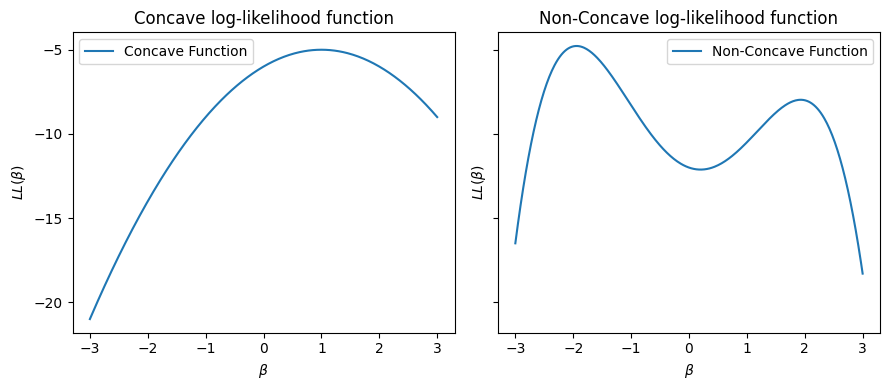

In [2]:
# Define the concave function
def concave_function(x):
    return -x**2 + 2*x + -6

# Define the non-concave function
def non_concave_function(x):
    return -0.4*x**4 + 0.1*x**3 + 3*x**2 - 1.2*x - 12

# Generate beta values
beta = np.linspace(-3, 3, 400)

# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharey=True,sharex=True)

# Plot the concave function
ax[0].plot(beta, concave_function(beta), label='Concave Function')
ax[0].set_title('Concave log-likelihood function')
ax[0].set_xlabel('$\\beta$')
ax[0].set_ylabel('$LL(\\beta)$')
ax[0].legend()
ax[0].set_yticks(np.arange(-20, 5, 5))

# Plot the non-concave function
ax[1].plot(beta, non_concave_function(beta), label='Non-Concave Function')
ax[1].set_title('Non-Concave log-likelihood function')
ax[1].set_xlabel('$\\beta$')
ax[1].set_ylabel('$LL(\\beta)$')
ax[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

`Based on the plot, we can make a couple of observations:`<br><br>
`1. The concave function have one maximum, while the concave function has more than one`<br><br>
`2. For the concave function, beta = 1 makes the data maximum likely; for the non-concave function beta ≈ -2  makes the data maximum likely.`

##### Proof
Now let's mathematically proof that these log-likelihood functions are concave and non-concave, respectively. <br>
To do so, we must compute the second derivative of the log-likelihood functions, w.r.t. beta.<br><br>

##### First order derivate of the concave log-likelihood function:

\begin{align*}
\frac{\partial LL(\beta)}{\partial \beta} &= \frac{\partial}{\partial \beta} \left( -\beta^2 + 2\beta - 6 \right) \\
\frac{\partial LL(\beta)}{\partial \beta} &= -2\beta + 2
\end{align*}

##### First order derivate of the non-concave log-likelihood function:

\begin{align*}
\frac{\partial LL(\beta)}{\partial \beta} &= \frac{\partial}{\partial \beta} \left( -0.4x^4 + 0.1x^3 + 3x^2 - 1.2x - 12 \right) \\
\frac{\partial LL(\beta)}{\partial \beta} &= -1.6x^3 + 0.3x^2 + 6x - 1.2
\end{align*}



Equating the first order derivatives to zero and **solving**, provides the optimal betas for the concave and non-concave functions, respectively.:<br>
For the concave function:
\begin{align*}
-2\beta + 2 &= 0 \\
\beta &= 1
\end{align*}

For the non-concave function:
\begin{align*}
-1.6x^3 + 0.3x^2 + 6x - 1.2 &= 0 \\
\beta &\approx -1.942 \\
\beta &\approx 0.200 \\
\beta &\approx 1.930 \\
\end{align*}
Note that to solve the non-concave function, we can used a numerical solver, as the main point here is to show that the non-concave function has multiple solutions.


##### Second order derivate of the concave log-likelihood function:

\begin{align*}
\frac{\partial^2 LL(\beta)}{\partial \beta^2} &= \frac{\partial}{\partial \beta} \left( -2\beta + 2 \right) \\
\frac{\partial^2 LL(\beta)}{\partial \beta^2} &= -2
\end{align*}

##### Second order derivate of the non-concave log-likelihood function:

\begin{align*}
\frac{\partial^2 LL(\beta)}{\partial \beta^2} &= \frac{\partial}{\partial \beta} \left( -1.6\beta^3 + 0.3\beta^2 + 6\beta - 1.2 \right) \\
\frac{\partial^2 LL(\beta)}{\partial \beta^2} &= -4.8\beta^2 + 0.6\beta + 6
\end{align*}

`--> Observations:`<br>
`1. The second order derivative of the concave function is negative in the entire domain, which is a necessary and sufficient condition for concativity.`<br><br>

`2. The second order derivative of the non-concave function is not negative in the entire domain, which is a necessary and sufficient condition for non-concavity.`

For completeness, we also plot the log-likelihood functions and their first and second order derivatives in the code below.

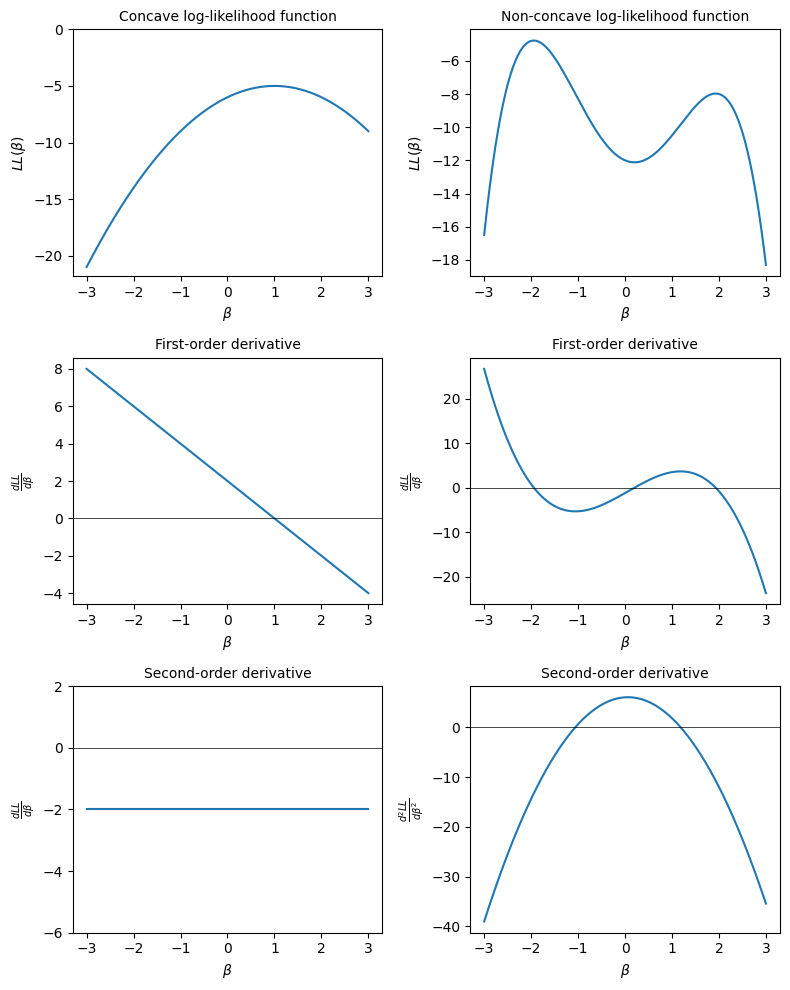

In [3]:
# Plot the second derivative of the concave function as a function of x
def frst_derivative_concave_function(x):
    return -2*x + 2

def frst_derivative_non_concave_function(x):
    return -1.6*x**3 + 0.3*x**2 + 6*x - 1.2

def scnd_derivative_concave_function(x):
    return -2 +0*x

def scnd_derivative_non_concave_function(x):
    return -4.8*x**2 + 0.6*x + 6

fig, ax = plt.subplots(3, 2, figsize=(8, 10))

# Plot the concave function
ax[0,0].plot(beta, concave_function(beta), label='Concave Function')
ax[0,0].set_title('Concave log-likelihood function', fontsize=10)
ax[0,0].set_xlabel('$\\beta$')
ax[0,0].set_ylabel('$LL(\\beta)$')
ax[0,0].set_yticks(np.arange(-20, 5, 5))

# Plot the non-concave function
ax[0,1].plot(beta, non_concave_function(beta), label='Non-concave Function')
ax[0,1].set_title('Non-concave log-likelihood function', fontsize=10)
ax[0,1].set_xlabel('$\\beta$')
ax[0,1].set_ylabel('$LL(\\beta)$')

# Plot the first derivative of the concave function
ax[1,0].plot(beta, frst_derivative_concave_function(beta), label='Concave Function')
ax[1,0].axhline(0, color='black', linewidth=0.5)
ax[1,0].set_title('First-order derivative', fontsize=10)
ax[1,0].set_xlabel('$\\beta$')
ax[1,0].set_ylabel('$\\frac{dLL}{d\\beta}$')

# Plot the first derivative of the non-concave function
ax[1,1].plot(beta, frst_derivative_non_concave_function(beta), label='Non-concave Function')
ax[1,1].axhline(0, color='black', linewidth=0.5)
ax[1,1].set_title('First-order derivative', fontsize=10)
ax[1,1].set_xlabel('$\\beta$')
ax[1,1].set_ylabel('$\\frac{dLL}{d\\beta}$')

# Plot the second derivative of the concave function
ax[2,0].plot(beta, scnd_derivative_concave_function(beta), label='Concave Function')
ax[2,0].axhline(0, color='black', linewidth=0.5)
ax[2,0].set_title('Second-order derivative', fontsize=10)
ax[2,0].set_xlabel('$\\beta$')
ax[2,0].set_ylabel('$\\frac{dLL}{d\\beta}$')
ax[2,0].set_yticks(np.arange(-6, 4, 2))

# Plot the second derivative of the non-concave function
ax[2,1].plot(beta, scnd_derivative_non_concave_function(beta), label='Non-concave Function')
ax[2,1].axhline(0, color='black', linewidth=0.5)
ax[2,1].set_title('Second-order derivative', fontsize=10)
ax[2,1].set_xlabel('$\\beta$')
ax[2,1].set_ylabel('$\\frac{d^2LL}{d\\beta^2}$')

# Show the plots
plt.tight_layout()
plt.show()

#### 2. Concavity of the log-likelihood function of the linear-additive RUM-MNL model

Now, let's proof that the log-likelihood function of the linear-additive RUM-MNL model is globally concave. <br>
To do so, we have to establish concavity. thus, we to proof that the second order-derivatives of the log-likelihood function wrt $\beta$ is negative in the entire domain. <br>
The log-likelihood function of a choice model is given by: <br>
\begin{align*}
LL(\beta) &= \sum_{n} \sum_{i} y_{ni} \ln P_{ni}
\end{align*}

Where:
- $n$ is the observation
- $i$ is an alternative
- $y_{ni}$ is a binary variable indicating 1 for the chosen alternative, and 0 for the non-chosen alternatives
- $ P_{ni} $ is the probability of choosing alternative $i$ for observation $n$.


Assuming utility is linear-additive RUM, the log-likelihood function can be written as: <br>

\begin{align*}
LL(\beta) &= \sum_{n} \sum_{i} y_{ni} \ln \left( \frac{e^{\beta' x_{ni}}}{\sum_{j} e^{\beta' x_{nj}}} \right) \\
          &= \sum_{n} \sum_{i} y_{ni} (\beta' x_{ni}) - \sum_{n} \sum_{i} y_{ni} \ln \left( \sum_{j} e^{\beta' x_{nj}} \right)
\end{align*}

Where:
- $\beta$ is the vector of parameters to be estimated
- $j$ is an alternative
- $x_{nj}$ is the vector of attributes of alternative $j$ for observation $n$

The first order derivative of the log-likelihood function of the RUM-MNL model w.r.t. $\beta$ is given by (see chapter 3 of Train (2009) for more details): <br>
\begin{align*}
\frac{\partial LL(\beta)}{\partial \beta}= \sum_{n} \sum_{i} (y_{ni} - P_{ni}) x_{ni}
\end{align*}


The second order derivative of the log-likelihood function of the RUM-MNL model w.r.t. $\beta$ is given by: <br>
\begin{align*}
\frac{\partial^2 LL(\beta)}{\partial \beta \partial \beta} = -\sum_{n} \sum_{i=1}^{2} \sum_{j=1}^{2} P_{ni} \left( \delta_{ij} - P_{nj} \right) x_{ni} x_{nj}'
\end{align*}

Where:
- $ \delta_{ij} $ is the Kronecker delta, equal to 1 if $i = j$ and 0 otherwise.


`--> It is still hard to see that the second order derivative is negative in the entire domain.`

 However, let's simplify our proof a bit by looking at the binary case, where we have just two alternatives. In this case, the second order derivative simplifies to: <br>

\begin{align*}
\frac{\partial^2 LL(\beta)}{\partial \beta \partial \beta} = - \sum_n P_{n1}(1 - P_{n1})(x_{n1} - x_{n2})(x_{n1} - x_{n2})'
\end{align*}

`--> This is a bit more manageable to show that the second order derivative is negative in the entire domain.`<br>
1. The term $P_{n1}(1 - P_{n1})$ is always positive, as it is the product of two probabilities.
1. The term $(x_{n1} - x_{n2})(x_{n1} - x_{n2})'$ is also always positive, as it is the outer product of a vector with itself (which always yields a positive semi-definite matrix). 

#### Empirical illustration
The analytical proof of the concavity of the log-likelihood function of the linear-additive RUM-MNL model may seem abacadabra. Therefore, we also illustrate this numerically by showing how the calculating the second order derivatives.

In [4]:
# Load synthetic choice data
data_path =  Path(f'data/synthetic_VTTdata_tutorial1.dat')
df = pd.read_csv(data_path)

# Show the data
print(df.shape)
df.head(10)


(1000, 6)


,RESP,TC1,TT1,TC2,TT2,CHOICE
0,1,4,35,8,25,2
1,1,4,35,8,30,2
2,1,6,40,7,20,2
3,1,5,30,6,25,2
4,1,5,40,7,20,1
5,2,4,35,8,25,1
6,2,4,35,8,30,1
7,2,6,40,7,20,2
8,2,5,30,6,25,2
9,2,5,40,7,20,2


First we compute the outer product of the difference in attributes of the two alternatives for each observation. Note that this is independent of the parameters $\beta$.

In [5]:
x_n1 = df.loc[0,['TC1', 'TT1']].values
x_n2 = df.loc[0,['TC2', 'TT2']].values
x_n1 - x_n2

array([-4, 10])

In [6]:
# Function to compute the diagonal of the outer product
def compute_diagonal(row):
    x_n1 = row[['TC1', 'TT1']].values
    x_n2 = row[['TC2', 'TT2']].values   
    x = np.outer(x_n1 - x_n2, x_n1 - x_n2)
    x = x.diagonal()
    return x

# Apply the function and add the result to the DataFrame
df[['x11', 'x22']] = df.apply(lambda row: pd.Series(compute_diagonal(row)), axis=1)
df.head(10)

,RESP,TC1,TT1,TC2,TT2,CHOICE,x11,x22
0,1,4,35,8,25,2,16,100
1,1,4,35,8,30,2,16,25
2,1,6,40,7,20,2,1,400
3,1,5,30,6,25,2,1,25
4,1,5,40,7,20,1,4,400
5,2,4,35,8,25,1,16,100
6,2,4,35,8,30,1,16,25
7,2,6,40,7,20,2,1,400
8,2,5,30,6,25,2,1,25
9,2,5,40,7,20,2,4,400


Next, we create a function to calculate the choice probabilities for each observation, given the a set of $\beta$ using the linear-additive RUM-MNL formula. 

In [50]:
# Create function to compute the choice probability, based on beta_tt and beta_tc
def compute_choice_probability(df, beta_tt, beta_tc):
    # Compute the utility for each alternative
    ASC1 = 0
    ASC2 = 1.099577 # Estimate of ASC from tutorial 1
    utility_1 = ASC1 + beta_tt * df['TT1'] + beta_tc * df['TC1']
    utility_2 = ASC2 + beta_tt * df['TT2'] + beta_tc * df['TC2']
    
    # Compute the probability of choosing alternative 1
    P1 = 1 / (1 + np.exp(utility_2 - utility_1))
    return P1

In [8]:
def compute_ddLL_dbdb(df, P1):
    
    # Compute the derivative of the log-likelihood function
    ddLL_dbdb =  P1 * (1 - P1) * (df['x11'].values - df['x22'].values)

    return ddLL_dbdb

Next, we calculate the second order derivative of the log-likelihood function of the RUM-MNL model w.r.t. $\beta$ for a given set of $\beta$.

Finally, we plot the second order derivative of the log-likelihood function of the RUM-MNL model w.r.t. $\beta$ for a range of $\beta$ values. 

`--> The plot shows that the second order derivative is negative in the entire domain, which confirms that the log-likelihood function of the linear-additive RUM-MNL model is globally concave.`

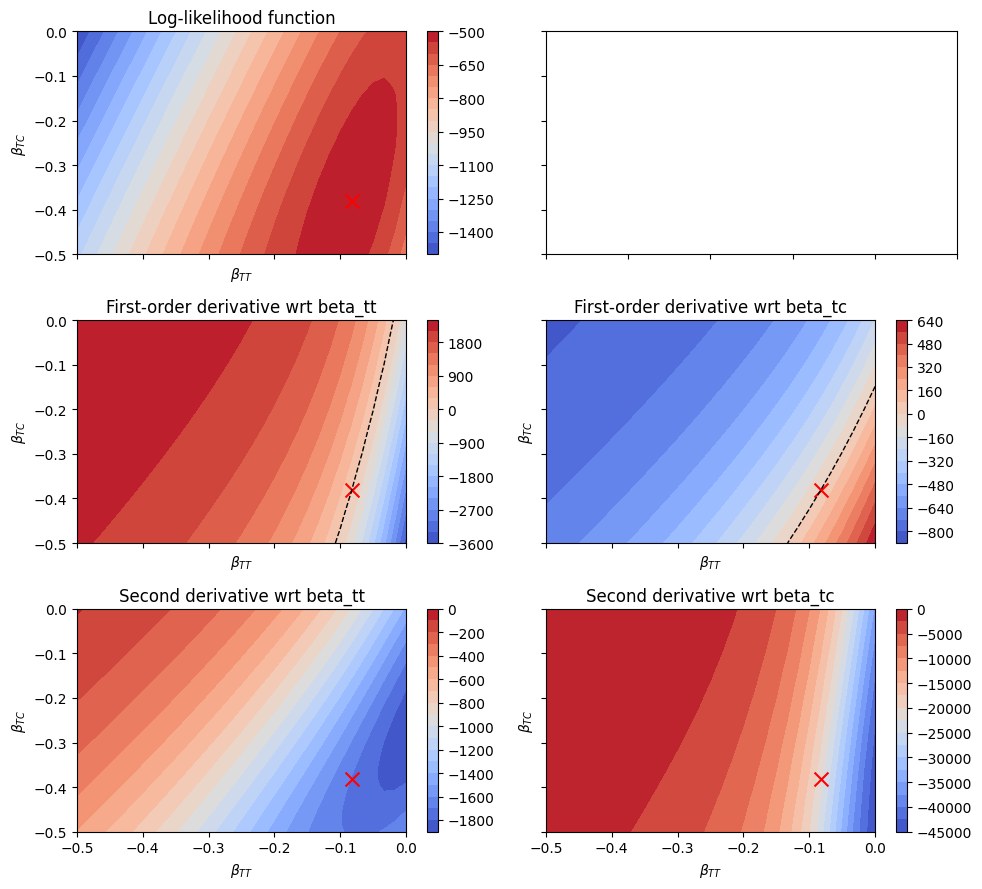

In [51]:
beta_tt = np.linspace(-0.5, 0, 31)
beta_tc = np.linspace(-0.5, 0, 31)

# Create a meshgrid
BETA_TT, BETA_TC = np.meshgrid(beta_tt, beta_tc)

# Compute the ... for each combination of beta_tt and beta_tc
LL = np.zeros_like(BETA_TT)
dLL_db1 = np.zeros_like(BETA_TT)
dLL_db2 = np.zeros_like(BETA_TT)
ddLL_db1db1 = np.zeros_like(BETA_TT)
ddLL_db2db2 = np.zeros_like(BETA_TT)
for i in range(BETA_TT.shape[0]):
    for j in range(BETA_TT.shape[1]):

        # Compute the choice probability alt 1
        P1 = compute_choice_probability(df, BETA_TT[i, j], BETA_TC[i, j])

        # Comppute the LL
        LL[i,j] = np.sum((df['CHOICE']==1)*np.log(P1) + (df['CHOICE']==2)*np.log(1-P1))

        # Compute the first-order derivative of the log-likelihood function
        # First-order derivative with respect to beta_tt
        dLL_db1[i,j] = np.sum(((df['CHOICE']==1)-P1)*(df['TT1'].values - df['TT2'].values))

        # First-order derivative with respect to beta_tc
        dLL_db2[i,j] = np.sum(((df['CHOICE']==1)-P1)*(df['TC1'].values - df['TC2'].values))


        # Compute the second-order derivative of the log-likelihood function
        # Second-order derivative with respect to beta_tt
        ddLL_db1db1[i,j] = -np.sum((P1 * (1 - P1)) * df['x11'].values)

        # Second-order derivative with respect to beta_tc
        ddLL_db2db2[i,j] = -np.sum((P1 * (1 - P1)) * df['x22'].values)

                                 

# Plot the second derivative of the log-likelihood function
fig, ax = plt.subplots(3, 2, figsize=(10, 9), sharex=True, sharey=True)

# Estimates of the beta parameters for tutorial 1
est_beta_tt = -0.082513
est_beta_tc = -0.381360

# Plot the log-likelihood function
c = ax[0,0].contourf(BETA_TT, BETA_TC, LL, levels=20, cmap='coolwarm')
fig.colorbar(c, ax=ax[0,0])
ax[0,0].set_title('Log-likelihood function')
ax[0,0].set_xlabel('$\\beta_{TT}$')
ax[0,0].set_ylabel('$\\beta_{TC}$')
ax[0,0].scatter(est_beta_tt, est_beta_tc, color='red', marker='x', s=100)


c = ax[1,0].contourf(BETA_TT, BETA_TC, dLL_db1, levels=20, cmap='coolwarm')
ax[1,0].contour(BETA_TT, BETA_TC, dLL_db1, levels=[0], colors='black', linewidths=1, linestyles='dashed')
fig.colorbar(c, ax=ax[1,0])
ax[1,0].set_title('First-order derivative wrt beta_tt')
ax[1,0].set_xlabel('$\\beta_{TT}$')
ax[1,0].set_ylabel('$\\beta_{TC}$')
ax[1,0].scatter(est_beta_tt, est_beta_tc, color='red', marker='x', s=100)

c = ax[1,1].contourf(BETA_TT, BETA_TC, dLL_db2, levels=20, cmap='coolwarm')
ax[1,1].contour(BETA_TT, BETA_TC, dLL_db2, levels=[0], colors='black', linewidths=1, linestyles='dashed')
fig.colorbar(c, ax=ax[1,1])
ax[1,1].set_title('First-order derivative wrt beta_tc')
ax[1,1].set_xlabel('$\\beta_{TT}$')
ax[1,1].set_ylabel('$\\beta_{TC}$')
ax[1,1].scatter(est_beta_tt, est_beta_tc,  color='red', marker='x', s=100)

c = ax[2,0].contourf(BETA_TT, BETA_TC, ddLL_db1db1, levels=20, cmap='coolwarm')
fig.colorbar(c, ax=ax[2,0])
ax[2,0].set_title('Second derivative wrt beta_tt')
ax[2,0].set_xlabel('$\\beta_{TT}$')
ax[2,0].set_ylabel('$\\beta_{TC}$')
ax[2,0].scatter(est_beta_tt, est_beta_tc, color='red', marker='x', s=100)

c = ax[2,1].contourf(BETA_TT, BETA_TC, ddLL_db2db2, levels=20, cmap='coolwarm')
fig.colorbar(c, ax=ax[2,1])
ax[2,1].set_title('Second derivative wrt beta_tc')
ax[2,1].set_xlabel('$\\beta_{TT}$')
ax[2,1].set_ylabel('$\\beta_{TC}$')
ax[2,1].scatter(est_beta_tt, est_beta_tc, color='red', marker='x', s=100)


plt.tight_layout()
plt.show()

In [19]:
BETA_TC[i, j]

np.float64(0.0)